# LMM usage example

Below we will fit a linear mixed model using the Ruby gem [mixed\_models](https://github.com/agisga/mixed_models), and demostrate many inference and prediction methods available for objects of class `LMM`.


## Table of Contents\*

* Example Data

* Linear Mixed Model

* Some model attributes

* Fitted values and residuals

* Fixed effects hypotheses tests and confidence intervals

* Predictions and prediction intervals

\* <sub>linking the titles to the respective sections messes up the display in nbviewer for some reason; would appreciate any hint on how to make it work...</sub>

## Example data

The data set, which is simulated, contains two numeric variables *Age* and *Aggression*, and two categorical variables *Location* and *Species*. These data are available for 100 (human and alien) individuals.

We will fit the model with the method `LMM#from_formula`, which mimics the behaviour of the function `lmer` from the `R` package `lme4`.

The data is supplied to `LMM#from_formula` as a `Daru::DataFrame` (from the excellent Ruby gem [daru](https://github.com/v0dro/daru.git)). We load the data, and display the first 10 lines with:

In [1]:
require 'daru'
alien_species = Daru::DataFrame.from_csv '../examples/data/alien_species.csv'
# mixed_models expects that all variable names in the data frame are ruby Symbols:
alien_species.vectors = Daru::Index.new(alien_species.vectors.map { |v| v.to_sym })
alien_species.head

#<Daru::DataFrame:46955646780340 @name = c2da3cf1-63c2-4a7d-9e31-ab70f2152bb8 @size = 10>
           Aggression        Age    Species   Location 
         0 877.542420     204.95      Dalek     Asylum 
         1 852.528392      39.88 WeepingAng  OodSphere 
         2 388.791416     107.34      Human     Asylum 
         3 170.010124     210.01        Ood  OodSphere 
         4 1078.31219     270.22      Dalek  OodSphere 
         5 164.924992     157.65        Ood  OodSphere 
         6 865.838374     136.15 WeepingAng  OodSphere 
         7 1052.36035     241.31      Dalek      Earth 
         8 -8.5725199      86.84        Ood     Asylum 
         9 1070.71900      206.7      Dalek  OodSphere

## Linear mixed model

We model the *Aggression* level of an individual as a linear function of the *Age* (*Aggression* decreases with *Age*), with a different constant added for each *Species* (i.e. each species has a different base level of aggression). Moreover, we assume that there is a random fluctuation in *Aggression* due to the *Location* that an individual is at. Additionally, there is a random fluctuation in how *Age* affects *Aggression* at each different *Location*. 

Thus, the *Aggression* level of an individual of *Species* $spcs$ who is at the *Location* $lctn$ can be expressed as:
$$Aggression = \beta_{0} + \gamma_{spcs} + Age \cdot \beta_{1} + b_{lctn,0} + Age \cdot b_{lctn,1} + \epsilon,$$
where $\epsilon$ is a random residual, and the random vector $(b_{lctn,0}, b_{lctn,1})^T$ follows a multivariate normal distribution (the same distribution but different realizations of the random vector for each *Location*). That is, we have a linear mixed model with fixed effects $\beta_{0}, \beta_{1}, \gamma_{Dalek}, \gamma_{Ood}, \dots$, and random effects $b_{Asylum,0}, b_{Asylum,1}, b_{Earth,0},\dots$.

We fit this model in `mixed_models` using a syntax familiar from the `R` package `lme4`, and display the estimated fixed and random effects coefficients:

In [2]:
require 'mixed_models'
model_fit = LMM.from_formula(formula: "Aggression ~ Age + Species + (Age | Location)", 
                             data: alien_species)
puts "Fixed effects:"
puts model_fit.fix_ef
puts "Random effects:"
puts model_fit.ran_ef

Fixed effects:
{:intercept=>1016.2867207023459, :Age=>-0.06531615342788907, :Species_lvl_Human=>-499.69369529020855, :Species_lvl_Ood=>-899.5693213535765, :Species_lvl_WeepingAngel=>-199.58895804200702}
Random effects:
{:intercept_Asylum=>-116.68080676073654, :Age_Asylum=>-0.0335339121374082, :intercept_Earth=>83.86571636827462, :Age_Earth=>-0.136139966451407, :intercept_OodSphere=>32.81508999155884, :Age_OodSphere=>0.16967387859160207}


## Some model attributes

Apart from the fixed and random effects coefficients (seen above), we can access many attributes of the fitted model. Among others:

* `fix_ef_names` and `ran_ef_names` are Arrays of names of the fixed and random effects.

* `reml` is an indicator whether the profiled REML criterion or the profiled deviance function was optimized by the model fitting algorithm.

* `formula` returns the R-like formula used to fit the model as a String.

* `model_data`, `optimization_result` and `dev_fun` store the various model matrices in an `LMMData` object, the results of the utilized optimization algorithm, and the corresponding objective function as a `Proc`.

* `sigma2` is the residual variance (unless `weights` was specified in the model fit).

* `sigma_mat` is the covariance matrix of the multivariate normal random effects vector.

We can look at some of these parameters for our example model:

In [3]:
puts "REML criterion used: \t#{model_fit.reml}"
puts "Residual variance: \t#{model_fit.sigma2}"
puts "Formula: \t" + model_fit.formula
puts "Variance of the intercept due to 'location' (i.e. variance of b0): \t#{model_fit.sigma_mat[0,0]}"
puts "Variance of the effect of 'age' due to 'location' (i.e. variance of b1): \t#{model_fit.sigma_mat[1,1]}"
puts "Covariance of b0 and b1: \t#{model_fit.sigma_mat[0,1]}"

REML criterion used: 	true
Residual variance: 	0.9496833447256825
Formula: 	Aggression ~ Age + Species + (Age | Location)
Variance of the intercept due to 'location' (i.e. variance of b0): 	10870.932406181171
Variance of the effect of 'age' due to 'location' (i.e. variance of b1): 	0.024233390356817094
Covariance of b0 and b1: 	-0.9716403033290799


Some further convenience methods are:

* `sigma` returns the square root of `sigma2`.

* `theta` returns the optimal solution of the minimization of the deviance function or the REML criterion (whichever was used to fit the model).

* `deviance` returns  the value of the deviance function or the REML criterion at the optimal solution.


In [4]:
puts "Residual standard deviation: \t#{model_fit.sigma}"
puts "REML criterion: \t#{model_fit.deviance}"

Residual standard deviation: 	0.9745169802141379
REML criterion: 	333.7155391015166


## Fitted values and residual

There are methods to get the fitted values of the response variable, with or without inclusion of random effects, as well as the model residuals.

In [5]:
puts "Fitted values at the population level:"
model_fit.fitted(with_ran_ef: false)

Fitted values at the population level:


[1002.9001750573, 814.0929544616347, 509.58198950318774, 103.00035396737837, 998.6369897230617, 106.42030776086267, 807.8049683711317, 1000.525279718662, 111.04534458509147, 1002.7858717888012, 1008.0797460241316, 498.79959889531176, 100.90435860387743, 111.03358767747443, 102.37593154060778, 812.6239941710414, 97.21856806594167, 800.9297900613121, 510.0032786927976, 502.6950542857511, 503.7329279637203, 999.8864877381372, 497.2875299434561, 1003.3325679929926, 804.1328942254158, 811.9113949371432, 99.91285939484214, 803.9356394420636, 998.4671677241491, 99.50267395131493, 500.71140270614603, 1014.38536747606, 112.41241167633723, 1010.303107886817, 114.52212343205804, 813.8107886788262, 811.7526766843134, 498.6990120190328, 1005.0836940663943, 110.67826780282678, 501.00205958890024, 810.6305451684223, 511.318092861301, 1000.7623773556052, 508.8465296155897, 1008.3730155530228, 1011.249538949987, 102.4595362169955, 1010.9490846442187, 1007.0346875692853, 506.2286581861998, 502.150317566

In [6]:
puts "Model residuals:"
model_fit.residuals

Model residuals:


[-1.8041727180516318, -1.1462465432206272, -0.5102357042338213, -1.438530578977577, 1.0108397561168658, -1.059491760131607, 2.1172177445057514, 0.8212947077424815, -0.024972828168071004, 0.04645157374602604, -0.2521512808752959, 0.5337610637689068, -0.5306298541011536, -0.8746282732136024, -0.5173146938876982, -1.076703511382675, -0.37352823345474917, 0.4342880104853748, -0.008686417241847266, 0.9633162152576915, -1.8591988675074163, -0.06035456182189591, -0.8747549066542888, 2.156663624530097, -0.12014582672816232, 1.5012618544112684, 0.5916114379897799, -1.4808531218288863, -0.16478112799086375, 2.0314537895963163, 0.010773844423852097, 0.8539551421497436, -1.2568149547061997, 0.07403493882179646, -0.11003692956987265, 1.027133585975207, 1.2893893800322758, -0.14846806796293777, -0.4342951733146947, 1.7157974749037237, 1.017366682325644, -0.6984875406660649, 0.16845508494236583, -1.423216161059372, -0.14893911781359748, 0.1337897922242064, -0.21024649931018757, 0.40638495225081783, -

We can assess the goodness of the model fit (to some extent) by plotting the residuals agains the fitted values, and checking for unexpected patterns. We use the gem [gnuplotrb](https://github.com/dilcom/gnuplotrb) for plotting.

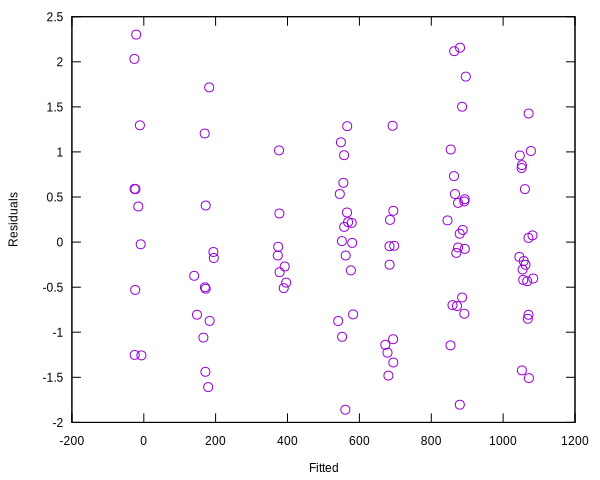

In [7]:
require 'gnuplotrb'
include GnuplotRB

x, y = model_fit.fitted, model_fit.residuals
fitted_vs_residuals = Plot.new([[x,y], with: 'points', pointtype: 6, notitle: true],
                               xlabel: 'Fitted', ylabel: 'Residuals')

We see that the residuals look more or less like noise, which is good.

We can further analyze the validity of the linear mixed model somewhat, by checking if the residuals appear to be approximately normally distributed.

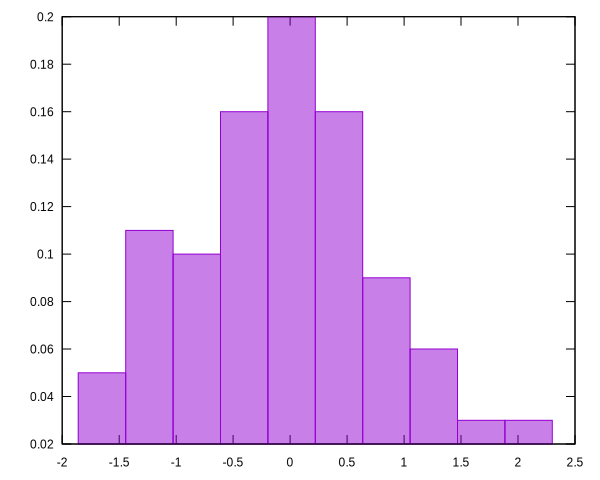

In [8]:
bin_width = (y.max - y.min)/10.0
bins = (y.min..y.max).step(bin_width).to_a
rel_freq = Array.new(bins.length-1){0.0}
y.each do |r|
  0.upto(bins.length-2) do |i|
    if r >= bins[i] && r < bins[i+1] then
      rel_freq[i] += 1.0/y.length
    end
  end
end
bins_center = bins[0...-1].map { |b| b + bin_width/2.0 }
  
residuals_hist = Plot.new([[bins_center, rel_freq], with: 'boxes', notitle: true],
                           style: 'fill solid 0.5')

The histogram does not appear to be too different from a bell shaped curve, although it might be slightly skewed to the right.

We can further explore the validity of the normality assumption by looking at the Q-Q plot of the residuals.

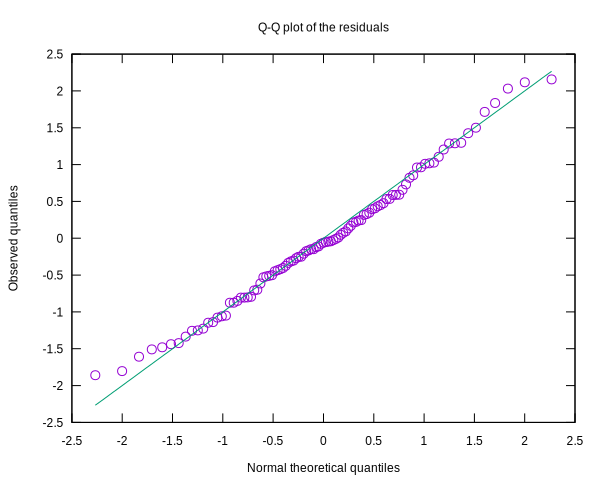

In [9]:
require 'distribution'

observed = model_fit.residuals.sort
n = observed.length
theoretical = (1..n).to_a.map { |t| Distribution::Normal.p_value(t.to_f/n.to_f) * model_fit.sigma}
qq_plot = Plot.new([[theoretical, observed], with: 'points', pointtype: 6, notitle: true],
                   ['x', with: 'lines', notitle: true],
                   xlabel: 'Normal theoretical quantiles', ylabel: 'Observed quantiles',
                   title: 'Q-Q plot of the residuals')

The straight line in the above plot is simply the diagonal. We see that the observed quantiles aggree with the theoretical values fairly well, as expected from a "good" model.

## Fixed effects hypotheses tests and confidence intervals

Often statistical models are used in order to determine which of the predictor variables have a significant relationship with the response variable. `LMM` has a number of methods to aid with this kind of statistical inference.

#### Variances and covariances of the fixed effects coefficient estimates

The covariance matrix of the fixed effects estimates is returned by `LMM#fix_ef_cov_mat`, and the standard deviations of the fixed effects coefficients are returned by `LMM#fix_ef_sd`. Methods for hypotheses tests and confidence intervals can be based on these values.

In [10]:
model_fit.fix_ef_sd

{:intercept=>60.19727495769054, :Age=>0.0898848636725299, :Species_lvl_Human=>0.2682523406941929, :Species_lvl_Ood=>0.28144708140043684, :Species_lvl_WeepingAngel=>0.27578357795259995}

#### Wald tests and confidence intervals

The [Wald Z test statistics](https://en.wikipedia.org/wiki/Wald_test#Test_on_a_single_parameter) for the fixed effects coefficients can be computed with:

In [11]:
model_fit.fix_ef_z

{:intercept=>16.882603430415077, :Age=>-0.7266646547504374, :Species_lvl_Human=>-1862.774781375937, :Species_lvl_Ood=>-3196.2289922406003, :Species_lvl_WeepingAngel=>-723.7158917283725}

Based on the above Wald Z test statistics, we can carry out hypotheses tests for each fixed effects terms $\beta_{i}$ or $\gamma_{species}$, testing the null $H_{0} : \beta_{i} = 0$ against the alternative $H_{a} : \beta_{i} \neq 0$, or respectively the null $H_{0} : \gamma_{species} = 0$ against the alternative $H_{a} : \gamma_{species} \neq 0$.

The corresponding (approximate) p-values are obtained with:

In [12]:
model_fit.fix_ef_p(method: :wald)

{:intercept=>0.0, :Age=>0.46743141066211646, :Species_lvl_Human=>0.0, :Species_lvl_Ood=>0.0, :Species_lvl_WeepingAngel=>0.0}

We see that the aggression level of each species is significantly different from the base level (which is the species `Dalek` in this model), while statistically we don't have enough evidence to conclude that the age of an individual is a good predictor of his/her/its aggression level.

We can use the Wald method for confidence intervals as well. For example 90% confidence intervals for each fixed effects coefficient estimate can be computed as follows.

In [13]:
conf_int = model_fit.fix_ef_conf_int(level: 0.9, method: :wald)

{:intercept=>[917.2710134723027, 1115.302427932389], :Age=>[-0.21316359921454495, 0.0825312923587668], :Species_lvl_Human=>[-500.1349311310106, -499.2524594494065], :Species_lvl_Ood=>[-900.0322606117453, -899.1063820954076], :Species_lvl_WeepingAngel=>[-200.04258166587707, -199.13533441813698]}

For greated visual clarity we can put the coefficient estimates and the confidence intervals into a `Daru::DataFrame`:

In [14]:
df = Daru::DataFrame.rows(conf_int.values, order: [:lower90, :upper90], index: model_fit.fix_ef_names)
df[:coef] = model_fit.fix_ef.values
df

#<Daru::DataFrame:46955645328660 @name = 4c3272ee-1764-46a7-a52c-d79dfbde2ba3 @size = 5>
              lower90    upper90       coef 
 intercept 917.271013 1115.30242 1016.28672 
       Age -0.2131635 0.08253129 -0.0653161 
Species_lv -500.13493 -499.25245 -499.69369 
Species_lv -900.03226 -899.10638 -899.56932 
Species_lv -200.04258 -199.13533 -199.58895

## Predictions and prediction intervals

One might also fit a statistical model in order to predict future observations based on new data input.

We consider the following new data set containing age, geographic location and species for ten individuals.

In [15]:
newdata = Daru::DataFrame.from_csv '../examples/data/alien_species_newdata.csv'
newdata.vectors = Daru::Index.new(newdata.vectors.map { |v| v.to_sym })
newdata

#<Daru::DataFrame:46955644970560 @name = 23340f13-4497-4a10-b38d-327a22232c3c @size = 10>
                  Age    Species   Location 
         0        209      Dalek  OodSphere 
         1         90        Ood      Earth 
         2        173        Ood     Asylum 
         3        153      Human     Asylum 
         4        255 WeepingAng  OodSphere 
         5        256 WeepingAng     Asylum 
         6         37      Dalek      Earth 
         7        146 WeepingAng      Earth 
         8        127 WeepingAng     Asylum 
         9         41        Ood     Asylum

#### Point estimates

Based on the fitted linear mixed model we can predict the aggression levels for the inidividuals, where we can specify whether the random effects estimates should be included in the calculations or not.

In [16]:
puts "Predictions of aggression levels on a new data set:"
pred =  model_fit.predict(newdata: newdata, with_ran_ef: true)

Predictions of aggression levels on a new data set:


[1070.9125752531208, 182.45206492790737, -17.06446875476354, 384.7881586199103, 876.1240725686446, 674.7113391148862, 1092.6985606350866, 871.1508855262363, 687.4629975728096, -4.016260100144294]

Now we can add the computed predictions to the data set, in order to see better which of the individuals are likely to be particularly dangerous.

In [17]:
newdata = Daru::DataFrame.from_csv '../examples/data/alien_species_newdata.csv'
newdata.vectors = Daru::Index.new(newdata.vectors.map { |v| v.to_sym })
newdata[:Predicted_Agression] = pred
newdata

#<Daru::DataFrame:46955644185960 @name = 7fb6e770-a46c-4229-89a2-aceabc04d9d7 @size = 10>
                  Age    Species   Location Predicted_ 
         0        209      Dalek  OodSphere 1070.91257 
         1         90        Ood      Earth 182.452064 
         2        173        Ood     Asylum -17.064468 
         3        153      Human     Asylum 384.788158 
         4        255 WeepingAng  OodSphere 876.124072 
         5        256 WeepingAng     Asylum 674.711339 
         6         37      Dalek      Earth 1092.69856 
         7        146 WeepingAng      Earth 871.150885 
         8        127 WeepingAng     Asylum 687.462997 
         9         41        Ood     Asylum -4.0162601

#### Interval estimates

Since the estimated fixed and random effects coefficients most likely are not exactly the true values, we probably should look at interval estimates of the predictions, rather than the point estimates computed above.

Two types of such interval estimates are currently available in `LMM`. On the one hand, a *confidence interval* is an interval estimate of the mean value of the response for given covariates (i.e. a population parameter); on the other hand, a *prediction interval* is an interval estimate of a future observation (for further explanation of this distinction see for example <https://stat.ethz.ch/education/semesters/ss2010/seminar/06_Handout.pdf>).

In [18]:
puts "88% confidence intervals for the predictions:"
ci = model_fit.predict_with_intervals(newdata: newdata, level: 0.88, type: :confidence)
Daru::DataFrame.new(ci, order: [:pred, :lower88, :upper88])

88% confidence intervals for the predictions:


#<Daru::DataFrame:46955643614720 @name = 3ee8cf14-9d44-4629-b8a0-36ff56e0e4c3 @size = 10>
                 pred    lower88    upper88 
         0 1002.63564 906.275473 1098.99581 
         1 110.838945 17.1539311 204.523959 
         2 105.417704 10.1646879 200.670721 
         3 506.599653 411.851919 601.347388 
         4 800.042143 701.909117 898.175169 
         5 799.976827 701.800945 898.152709 
         6 1013.87002 920.443931 1107.29611 
         7 807.161604 712.571759 901.751449 
         8 808.402611 714.191640 902.613582 
         9 114.039437 20.6140348 207.464839

In [19]:
puts "88% prediction intervals for the predictions:"
pi = model_fit.predict_with_intervals(newdata: newdata, level: 0.88, type: :prediction)
Daru::DataFrame.new(pi, order: [:pred, :lower88, :upper88])

88% prediction intervals for the predictions:


#<Daru::DataFrame:46955643188840 @name = 4ab2a0ba-cd75-4d5e-80c6-f758c94c17f7 @size = 10>
                 pred    lower88    upper88 
         0 1002.63564 809.910050 1195.36123 
         1 110.838945 -76.536158 298.214049 
         2 105.417704 -85.093528 295.928938 
         3 506.599653 317.098899 696.100408 
         4 800.042143 603.771398 996.312888 
         5 799.976827 603.620377 996.333277 
         6 1013.87002 827.012723 1200.72732 
         7 807.161604 617.976730 996.346478 
         8 808.402611 619.975479 996.829743 
         9 114.039437 -72.816144 300.895018